## Bank Note Authentication

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

Dataset can be used for Binary Classification sample problems.

[Link to Dataset](https://www.kaggle.com/ritesaluja/bank-note-authentication-uci-data?select=BankNote_Authentication.csv)

### Importing Libraries and Dataset

In [1]:
# Importing libraries
import pylab
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset
df = pd.read_csv('BankNote_Authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


### Exploratory Data Analysis

In [3]:
# Checking for null values
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [4]:
# Getting some stats about data
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [5]:
# Extracting dependent and independent features
X = df.drop('class', axis=1)
Y = df['class']

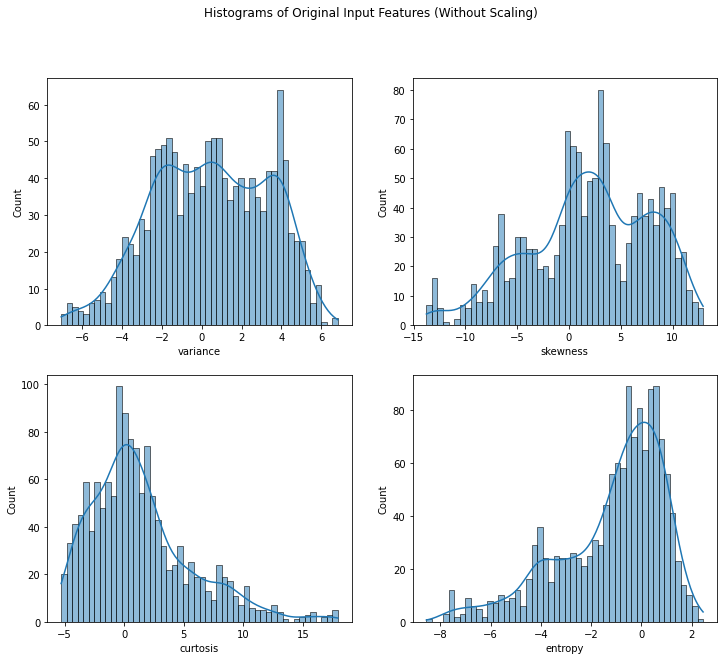

In [6]:
# Plotting histograms
figure, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle('Histograms of Original Input Features (Without Scaling)')
sns.histplot(data=X['variance'], kde=True, ax=axes[0, 0], bins=50)
sns.histplot(data=X['skewness'], kde=True, ax=axes[0, 1], bins=50)
sns.histplot(data=X['curtosis'], kde=True, ax=axes[1, 0], bins=50)
sns.histplot(data=X['entropy'], kde=True, ax=axes[1, 1], bins=50)
plt.show()

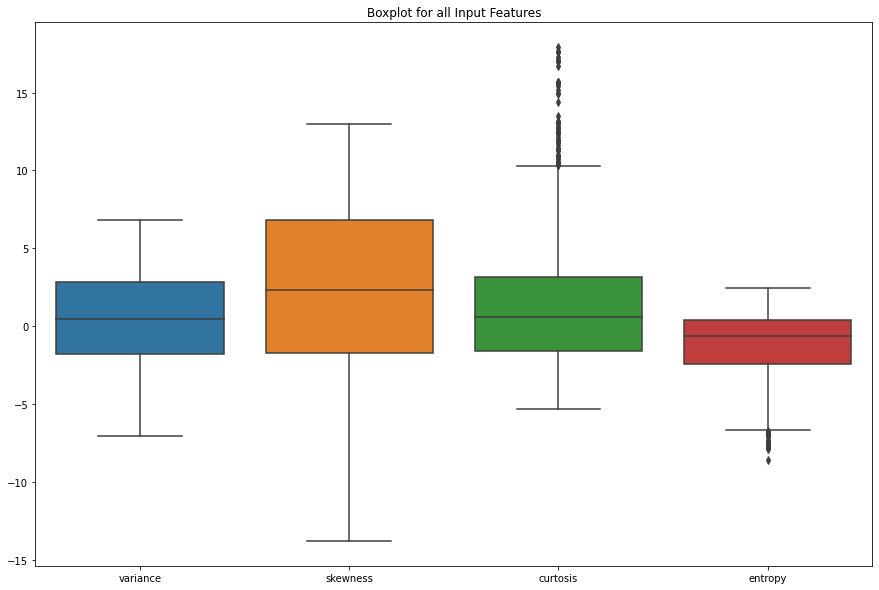

In [7]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=X)
plt.title('Boxplot for all Input Features')
plt.show()

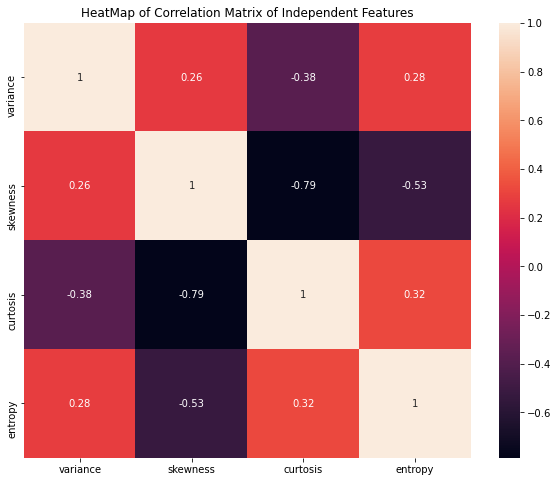

In [8]:
# Plotting the heat map of correlation matrix for input features
plt.figure(figsize=(10, 8))
sns.heatmap(data=X.corr(), annot=True)
plt.title('HeatMap of Correlation Matrix of Independent Features')
plt.show()

In [9]:
# Function to plot histogram and Q-Q plot
def plot_QQ(df, feature):
    plt.figure(figsize=(12, 6))
    plt.suptitle(feature)
    plt.subplot(1, 2, 1)
    plt.title('Histogram')
    sns.histplot(data=df[feature], bins=50)
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist='norm', plot=pylab)
    plt.show()

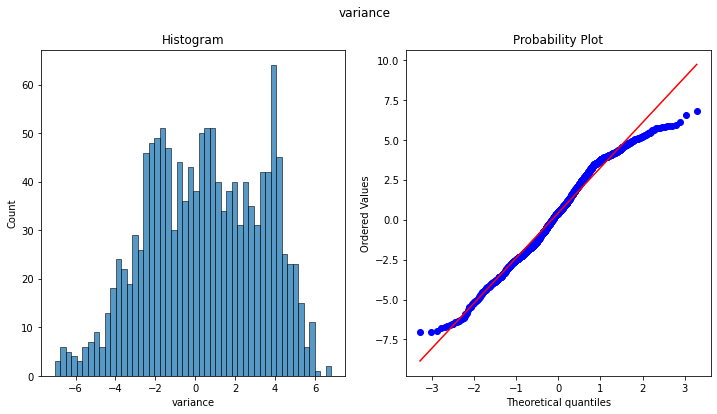

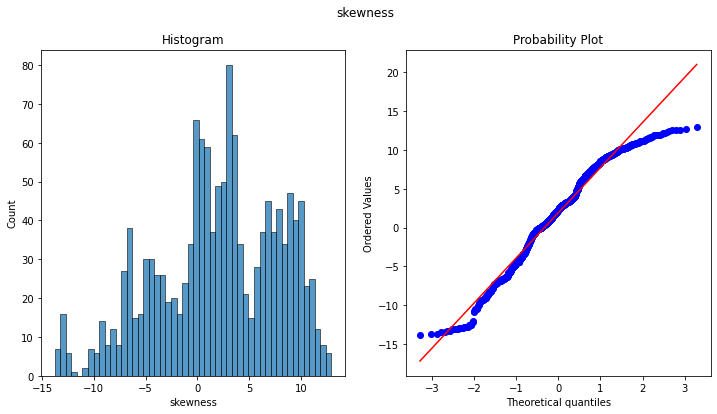

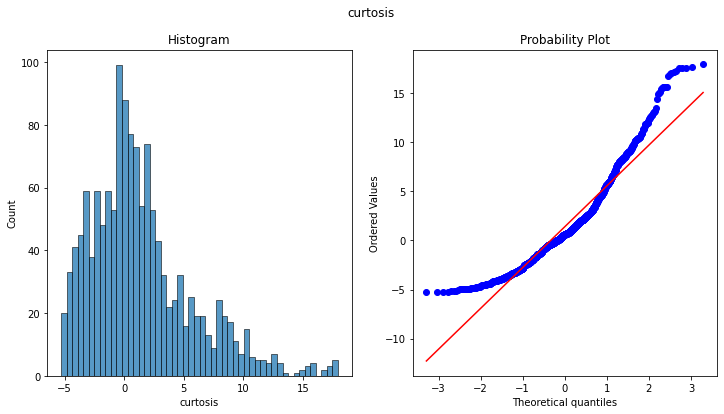

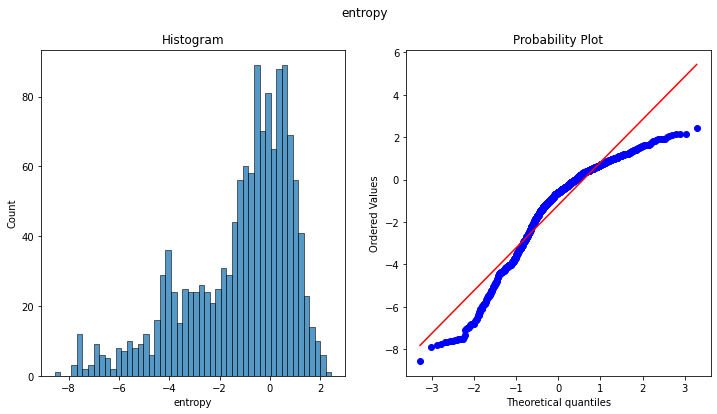

In [10]:
# Plotting histograms and Q-Q plots
for feature in X.columns:
    plot_QQ(X, feature)

### Train Test Split

In [11]:
# Splitting the dataset into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=0)
print('Shape of X_train :', X_train.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of X_test  :', X_test.shape)
print('Shape of y_test  :', y_test.shape)

Shape of X_train : (1097, 4)
Shape of y_train : (1097,)
Shape of X_test  : (275, 4)
Shape of y_test  : (275,)


### Feature Engineering

In [12]:
# Applying standard scaling to training input features
standard_scaler = StandardScaler()
X_train = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)
X_train.head()

,variance,skewness,curtosis,entropy
0,-0.602350,0.137063,-0.524413,-0.411162
1,-0.291035,0.210264,-1.023687,-0.725851
2,-0.682662,-1.442295,1.029489,0.980744
3,-0.245143,1.088675,-1.064457,-0.648436
4,1.153810,0.882653,-0.762351,0.500668


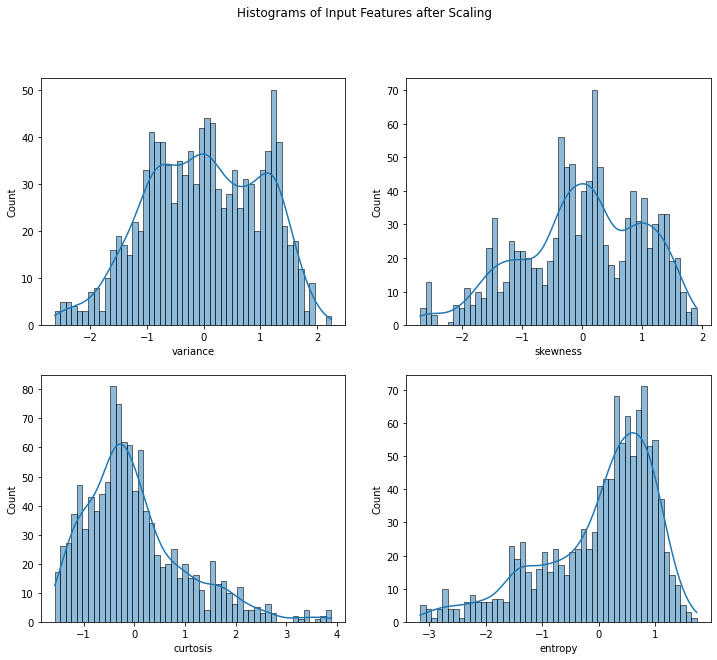

In [13]:
# Plotting histograms
figure, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle('Histograms of Input Features after Scaling')
sns.histplot(data=X_train['variance'], kde=True, ax=axes[0, 0], bins=50)
sns.histplot(data=X_train['skewness'], kde=True, ax=axes[0, 1], bins=50)
sns.histplot(data=X_train['curtosis'], kde=True, ax=axes[1, 0], bins=50)
sns.histplot(data=X_train['entropy'], kde=True, ax=axes[1, 1], bins=50)
plt.show()

### Model Building

#### Logistic Regression

In [14]:
# Defining hyperparameter values to tune over
grid_params = {
    'C' : 10.0 ** np.arange(-2, 2),
    'penalty' : ['l1', 'l2'],
    'class_weight' : [{0:1, 1:10}, {0:1, 1:100}, {0:1, 1:1000}, {0:1, 1:10000}]
}

In [15]:
# Instantiating and training a Logistic Regression model
logistic_classifier = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid=grid_params, cv=3, n_jobs=-1)
logistic_classifier.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 100},
                                          {0: 1, 1: 1000}, {0: 1, 1: 10000}],
                         'penalty': ['l1', 'l2']})

In [16]:
# Printing hyperparameter values for best logistic regression model
print('best hyperparamters:', logistic_classifier.best_params_)

# Creating final logistic regression model with best hyperparameter values
logistic_classifier = LogisticRegression(C=10.0, class_weight={0:1,1:10}, penalty='l2', n_jobs=-1)
logistic_classifier.fit(X_train, y_train)

best hyperparamters: {'C': 10.0, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2'}


LogisticRegression(C=10.0, class_weight={0: 1, 1: 10}, n_jobs=-1)

In [17]:
# Predicting on test data and printing metrics
y_pred = logistic_classifier.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy Score: 0.9890909090909091

Confusion Matrix:
 [[154   3]
 [  0 118]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       157
           1       0.98      1.00      0.99       118

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



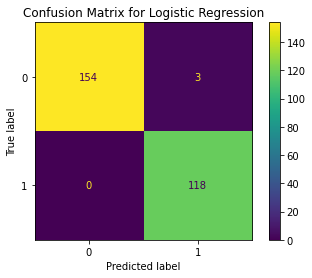

In [18]:
# Plotting confusion matrix for visualization
plot_confusion_matrix(logistic_classifier, X_test, y_test)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

#### Support Vector Classifier

In [19]:
# Defining hyperparameter values to tune over
grid_params = {
    'C' : 10.0 ** np.arange(-2, 2),
    'kernel' : ['linear', 'rbf'],
    'class_weight' : [{0:1, 1:10}, {0:1, 1:100}, {0:1, 1:1000}, {0:1, 1:10000}]
}

In [20]:
# Instantiating and training a Logistic Regression model
support_vector_classifier = GridSearchCV(SVC(), param_grid=grid_params, cv=3, n_jobs=-1)
support_vector_classifier.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 100},
                                          {0: 1, 1: 1000}, {0: 1, 1: 10000}],
                         'kernel': ['linear', 'rbf']})

In [21]:
# Printing hyperparameter values for best logistic regression model
print('best hyperparamters:', support_vector_classifier.best_params_)

# Creating final logistic regression model with best hyperparameter values
support_vector_classifier = SVC(C=10.0, class_weight={0:1,1:10}, kernel='rbf')
support_vector_classifier.fit(X_train, y_train)

best hyperparamters: {'C': 10.0, 'class_weight': {0: 1, 1: 10}, 'kernel': 'rbf'}


SVC(C=10.0, class_weight={0: 1, 1: 10})

In [22]:
# Predicting on test data and printing metrics
y_pred = support_vector_classifier.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy Score: 1.0

Confusion Matrix:
 [[157   0]
 [  0 118]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       118

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



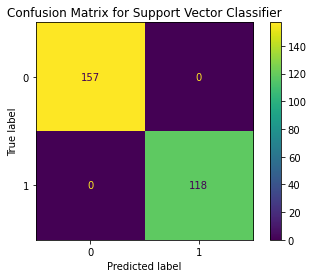

In [23]:
# Plotting confusion matrix for visualization
plot_confusion_matrix(support_vector_classifier, X_test, y_test)
plt.title('Confusion Matrix for Support Vector Classifier')
plt.show()

#### Random Forest Classifier

In [24]:
# Defining hyperparameter values to tune over
grid_params = {
    'n_estimators' : [100, 250, 500],
    'class_weight' : [{0:1, 1:1}, {0:1, 1:100}, {0:1, 1:1000}]
}

In [25]:
# Instantiating and training a Logistic Regression model
random_forest_classifier = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid=grid_params, cv=3, n_jobs=-1)
random_forest_classifier.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 100},
                                          {0: 1, 1: 1000}],
                         'n_estimators': [100, 250, 500]})

In [26]:
# Printing hyperparameter values for best logistic regression model
print('best hyperparamters:', random_forest_classifier.best_params_)

# Creating final logistic regression model with best hyperparameter values
random_forest_classifier = RandomForestClassifier(n_estimators=250, class_weight={0:1,1:1}, n_jobs=-1)
random_forest_classifier.fit(X_train, y_train)

best hyperparamters: {'class_weight': {0: 1, 1: 1}, 'n_estimators': 500}


RandomForestClassifier(class_weight={0: 1, 1: 1}, n_estimators=250, n_jobs=-1)

In [27]:
# Predicting on test data and printing metrics
y_pred = random_forest_classifier.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy Score: 0.9854545454545455

Confusion Matrix:
 [[155   2]
 [  2 116]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       157
           1       0.98      0.98      0.98       118

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



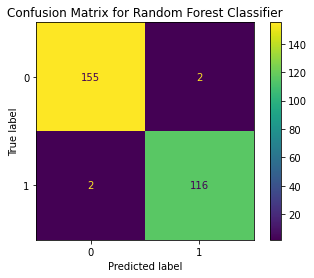

In [28]:
# Plotting confusion matrix for visualization
plot_confusion_matrix(random_forest_classifier, X_test, y_test)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

### Exporting the Model

In [29]:
# Exporting the models and standard scaler to pickle files

with open('models.pkl', 'wb') as file:
    pickle.dump([logistic_classifier, support_vector_classifier, random_forest_classifier], file)
    
with open('standard_scaler.pkl', 'wb') as file:
    pickle.dump(standard_scaler, file)